<h1>Importing essential libraries</h1>

In [1]:
import sys
!{sys.executable} -m pip install pandas-profiling
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip  install imblearn
!{sys.executable} -m pip  install catboost

In [1]:
# Importing essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt

# Importing various models and tools 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<h1>Importing Dataset</h1>

We import the dataset that has been cleaned and does not contain any duplicates. This is because the dataset used in `2.1 Modelling without Duplicates` gives us the model with the highest classification accuracy compared to the datasets used in `2.2 Modelling without Outliers`, `2.3 Modelling with Feature Selection`, and `2.4 Modelling without Outliers and with Feature Selection`.

In [2]:
wine_data = pd.read_csv("binned_no_dup.csv")

wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,0.529065
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.499338
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,1.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


# Machine Learning

<h2> SMOTE </h2>

We apply Synthetic Minority Oversampling Technique (SMOTE) to the cleaned dataset to ensure a more even distribution in the quality bin. SMOTE does this by generating new instances from existing minority cases supplied. In our case, SMOTE will increase the number of data points wtith quality = 'bad', which is the current minority.

As shown below, after SMOTE-ing the dataset, the dataset now has an equal number of data points with quality = 'good' and quality = 'bad'.

In [3]:
from imblearn.over_sampling import SMOTE

target_label = 'quality'
X = wine_data.drop([target_label], axis=1)
y = wine_data[target_label]

print("Quality value counts before SMOTE: \n", y.value_counts())

smote = SMOTE(k_neighbors=4, random_state=42)
X_smote, y_smote = smote.fit_resample(X,y)

print("Quality value counts after SMOTE: \n", y_smote.value_counts())

Quality value counts before SMOTE: 
 1    719
0    640
Name: quality, dtype: int64
Quality value counts after SMOTE: 
 1    719
0    719
Name: quality, dtype: int64


([<matplotlib.axis.XTick at 0x23370a5ec40>,
 <a list of 2 Text major ticklabel objects>)

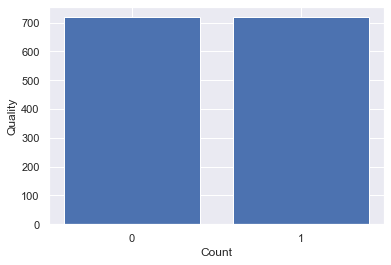

In [4]:
plt.bar(x = y_smote.value_counts().index.tolist(),
       height = y_smote.value_counts())
plt.xlabel('Count')
plt.ylabel('Quality')
plt.xticks([0,1])

<h2> Train Test Split </h2>

We use the train_test_split() function to split the dataset into the train set, and the test set, with a test size of 0.2.
We also specify stratify = y_smote. This is to ensure that the ratio of good:bad values are consistent throughout the train set and the test set.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state = 42)

<h2>Model Fitting & Hyperparameter Tuning</h2>

For each of the models used below, the GridSearchCV function is used to determine the optimal hyperparameters for each model (i.e. the hyperparameters which result in the highest accuracy scores on the trainset). 5-fold cross validation is used to obtain unbiased results as well as to determine the optimal hyperparameters of each model.

In [6]:
# Importing libraries used for model fitting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

<H2> (1) Logistic Regression </H2>

Logistic regression is a process of modeling the probability of a discrete outcome given an input variable. Logistic regression is a useful analysis method for classification problems, where you are trying to determine if a new sample fits best into a category. 
It is a simple and more efficient method for binary and linear classification problems. It performs relatively well in our dataset as our response variables are binary. 


In [7]:
param_grid = {'penalty':['l1', 'l2', 'elasticnet'],
              'C': np.logspace(-3, 3, 7),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'random_state': [42]}

grid_search_logreg = GridSearchCV(LogisticRegression(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=1)
grid_search_logreg.fit(X_train,y_train)
print("Best parameters: ", grid_search_logreg.best_params_)
print("Best CV score: ", grid_search_logreg.best_score_)

best_logreg = LogisticRegression(**grid_search_logreg.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_logreg.score(X_test, y_test))

Best parameters:  {'C': 1.0, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
Best CV score:  0.7460869565217391
Test accuracy:  0.7256944444444444


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7495652173913043
True Positive Rate 		: 0.7321739130434782
False Positive Rate 		: 0.23304347826086957
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7256944444444444
True Positive Rate 		: 0.6666666666666666
False Positive Rate 		: 0.2152777777777778


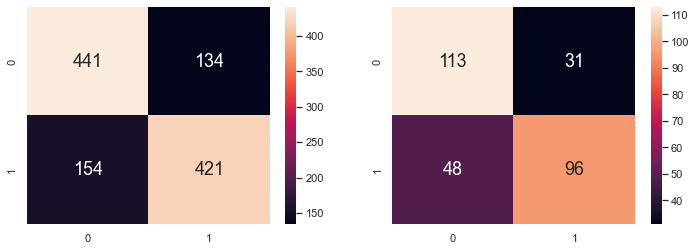

In [8]:
pred_train = best_logreg.predict(X_train)
pred_test = best_logreg.predict(X_test)

CM_train = confusion_matrix(y_train, pred_train)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", best_logreg.score(X_train, y_train))
print("True Positive Rate \t\t:", TP_train/(TP_train + FN_train))
print("False Positive Rate \t\t:", FP_train/(FP_train + TN_train))

CM_test = confusion_matrix(y_test, pred_test)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0]
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", best_logreg.score(X_test, y_test))
print("True Positive Rate \t\t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t\t:", FP_test/(FP_test + TN_test))
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, pred_train),
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, pred_test), 
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

We show the confusion matrix generated by the model for both the train dataset and the test dataset.

<h2> (2) Gaussian Naive Bayes </h2>

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. 

For our dataset, we chose to use Gaussian Naive Bayes where the likelihood of each predictor is assumed to be Gaussian (normal distribution).

In [9]:
param_grid = {'var_smoothing': np.logspace(0,-9, num=100),}

grid_search_gnb = GridSearchCV(GaussianNB(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)
grid_search_gnb.fit(X_train,y_train)
print("Best parameters: ", grid_search_gnb.best_params_)
print("Best CV score: ", grid_search_gnb.best_score_)

best_gnb = GaussianNB(**grid_search_gnb.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_gnb.score(X_test, y_test))

Best parameters:  {'var_smoothing': 5.336699231206313e-06}
Best CV score:  0.7252173913043478
Test accuracy:  0.7256944444444444


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7330434782608696
True Positive Rate 		: 0.6869565217391305
False Positive Rate 		: 0.22086956521739132
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7256944444444444
True Positive Rate 		: 0.6527777777777778
False Positive Rate 		: 0.2013888888888889


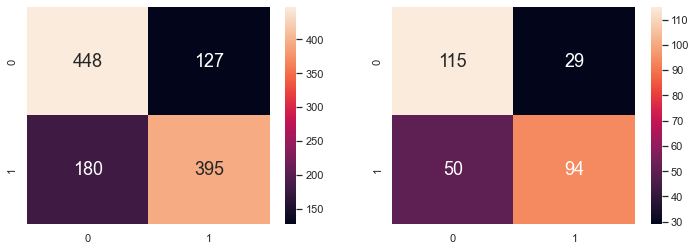

In [10]:
pred_train = best_gnb.predict(X_train)
pred_test = best_gnb.predict(X_test)

CM_train = confusion_matrix(y_train, pred_train)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", best_gnb.score(X_train, y_train))
print("True Positive Rate \t\t:", TP_train/(TP_train + FN_train))
print("False Positive Rate \t\t:", FP_train/(FP_train + TN_train))

CM_test = confusion_matrix(y_test, pred_test)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0]
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", best_gnb.score(X_test, y_test))
print("True Positive Rate \t\t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t\t:", FP_test/(FP_test + TN_test))
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, pred_train),
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, pred_test), 
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


We show the confusion matrix generated by the model for both the train dataset and the test dataset.

<h2> (3) Decision Tree Classifier </h2>

The Decision Tree Classifier belongs to the family of supervised learning algorithms. The intuition behind Decision Trees is that you use the dataset features to create yes/no questions and continually split the dataset until you isolate all data points belonging to each class. The Decision Tree classifier can handle both categorical and numerical data (numerical data as predictors in this dataset), and is simple to understand and interpret since the trees can be visualised.

In [11]:
param_grid = {'max_depth':[i for i in range(1,50,1)],
             'random_state': [42]}

grid_search_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_dtc.fit(X_train,y_train)
print("Best parameters: ", grid_search_dtc.best_params_)
print("Best CV score: ", grid_search_dtc.best_score_)

best_dtc = DecisionTreeClassifier(**grid_search_dtc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_dtc.score(X_test, y_test))

Best parameters:  {'max_depth': 4, 'random_state': 42}
Best CV score:  0.7243478260869566
Test accuracy:  0.6770833333333334


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7713043478260869
True Positive Rate 		: 0.6469565217391304
False Positive Rate 		: 0.10434782608695652
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6770833333333334
True Positive Rate 		: 0.5347222222222222
False Positive Rate 		: 0.18055555555555555


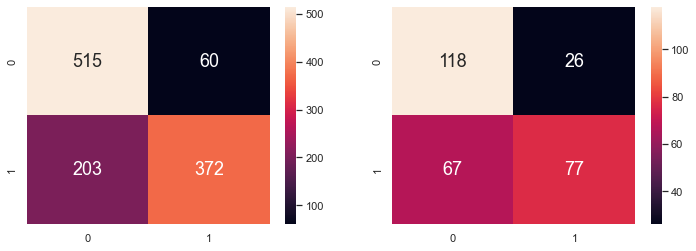

In [12]:
pred_train = best_dtc.predict(X_train)
pred_test = best_dtc.predict(X_test)

CM_train = confusion_matrix(y_train, pred_train)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", best_dtc.score(X_train, y_train))
print("True Positive Rate \t\t:", TP_train/(TP_train + FN_train))
print("False Positive Rate \t\t:", FP_train/(FP_train + TN_train))

CM_test = confusion_matrix(y_test, pred_test)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0]
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", best_dtc.score(X_test, y_test))
print("True Positive Rate \t\t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t\t:", FP_test/(FP_test + TN_test))
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, pred_train),
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, pred_test), 
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

We show the confusion matrix generated by the model for both the train dataset and the test dataset. As the model performs significantly better with the train dataset, the model may have been overfitted to the train dataset, and thus does not generalise to the test dataset very well.

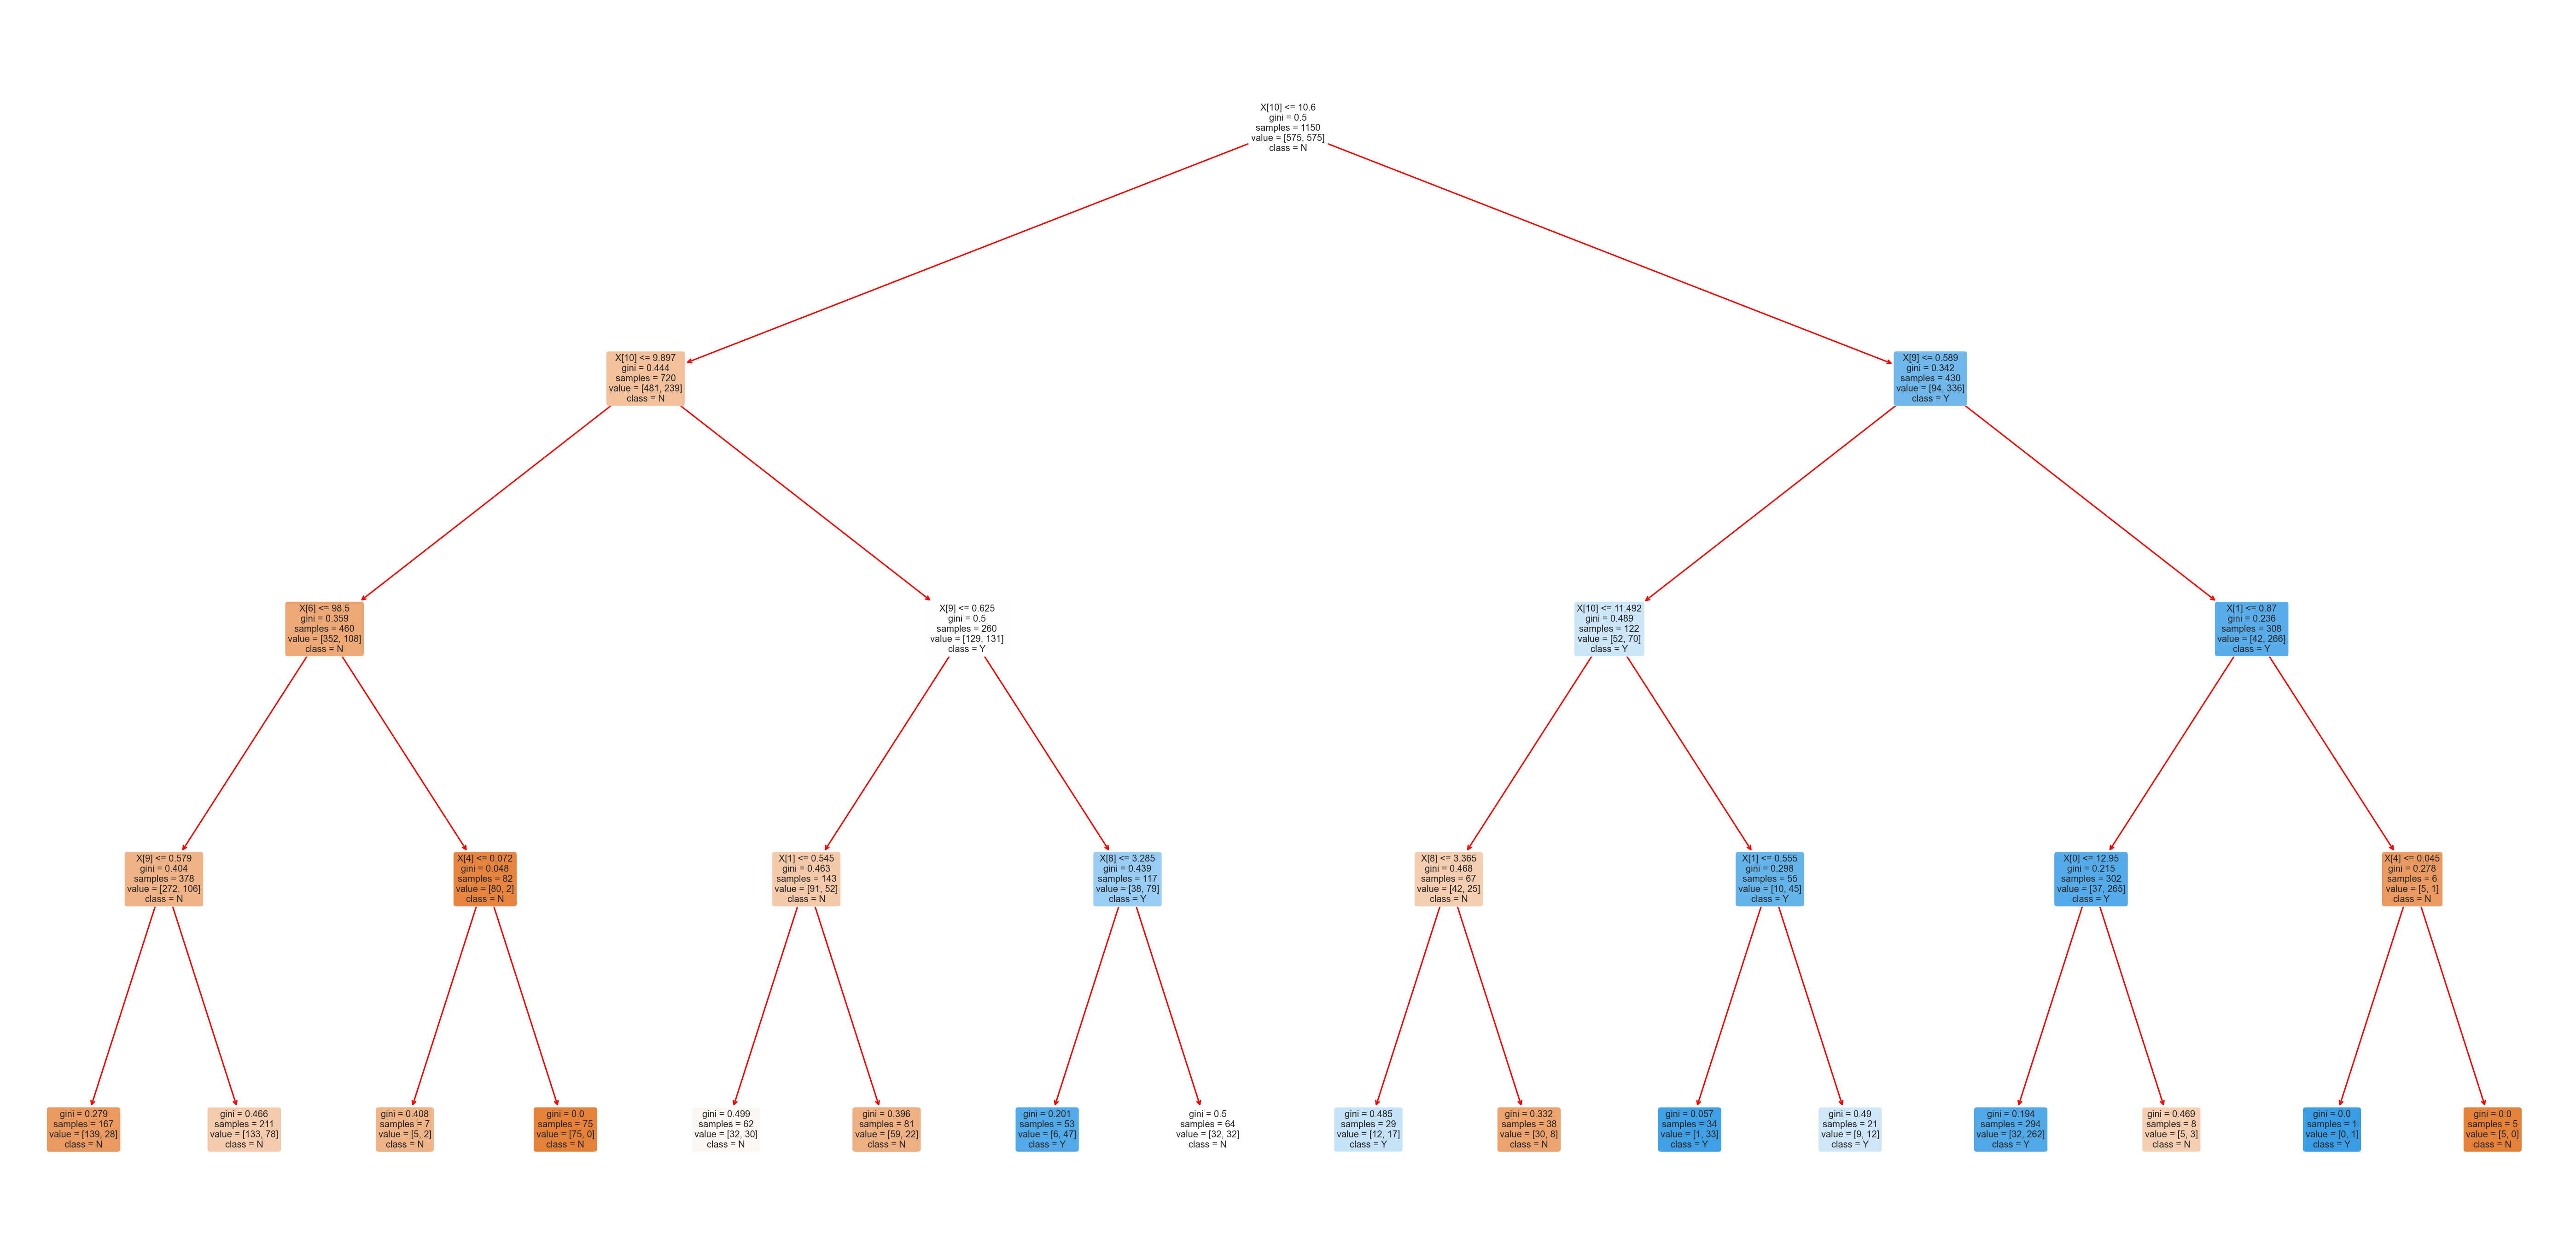

In [13]:
# Visualising the decision tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(100,50))
out = plot_tree(best_dtc, filled=True, rounded=True,fontsize=20, class_names=["N","Y"])
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('red')
        arrow.set_linewidth(3)

We plot out the decision tree generated from the model for visualisation purpose.

<h2> (4) Random Forest Classifier </h2>

The Random Forest Classifier builds multiple decision trees and merges them together to get a more accurate and stable prediction. One big advantage of random forest is that it can be used for both classification and regression problems, and is suitable for binary classification of wines in this dataset.  Random forest adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in an improved model.

In [14]:
param_grid = {'max_depth':[i for i in range(1,30,3)],
             'n_estimators': [j for j in range(10, 601, 40)],
             'random_state': [42]}


grid_search_rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_rfc.fit(X_train,y_train)
print("Best parameters: ", grid_search_rfc.best_params_)
print("Best CV score: ", grid_search_rfc.best_score_)

best_rfc = RandomForestClassifier(**grid_search_rfc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_rfc.score(X_test, y_test))

Best parameters:  {'max_depth': 13, 'n_estimators': 130, 'random_state': 42}
Best CV score:  0.7617391304347827
Test accuracy:  0.7743055555555556


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 1.0
True Positive Rate 		: 1.0
False Positive Rate 		: 0.0
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7743055555555556
True Positive Rate 		: 0.7430555555555556
False Positive Rate 		: 0.19444444444444445


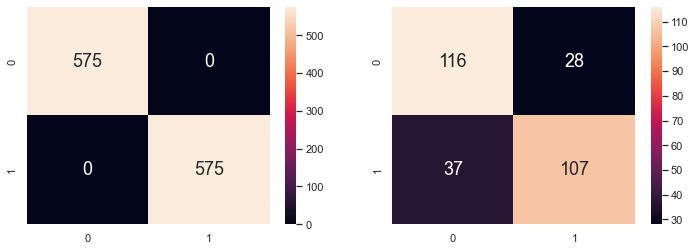

In [15]:
pred_train = best_rfc.predict(X_train)
pred_test = best_rfc.predict(X_test)

CM_train = confusion_matrix(y_train, pred_train)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", best_rfc.score(X_train, y_train))
print("True Positive Rate \t\t:", TP_train/(TP_train + FN_train))
print("False Positive Rate \t\t:", FP_train/(FP_train + TN_train))

CM_test = confusion_matrix(y_test, pred_test)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0]
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", best_rfc.score(X_test, y_test))
print("True Positive Rate \t\t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t\t:", FP_test/(FP_test + TN_test))
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, pred_train),
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, pred_test), 
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

We show the confusion matrix generated by the model for both the train dataset and the test dataset. As the model performs significantly better with the train dataset, the model may have been overfitted to the train dataset, and thus does not generalise to the test dataset very well.

<h2> (5) AdaBoost Classifier </h2>

AdaBoost is an iterative ensemble method. AdaBoost classifier builds a strong classifier by combining multiple poorly performing classifiers so that you will get a high accuracy strong classifier. The method automatically adjusts its parameters to the data based on the actual performance in the current iteration, meaning, both the weights for re-weighting the data and the weights for the final aggregation are re-computed iteratively.


In [16]:
param_grid = {'learning_rate':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
             'n_estimators': [j for j in range(10, 601, 40)],
             'random_state': [42]}

grid_search_abc = GridSearchCV(AdaBoostClassifier(), param_grid, cv= KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_abc.fit(X_train,y_train)
print("Best parameters: ", grid_search_abc.best_params_)
print("Best CV score: ", grid_search_abc.best_score_)

best_abc = AdaBoostClassifier(**grid_search_abc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_abc.score(X_test, y_test))

Best parameters:  {'learning_rate': 0.15, 'n_estimators': 250, 'random_state': 42}
Best CV score:  0.7591304347826087
Test accuracy:  0.7569444444444444


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.808695652173913
True Positive Rate 		: 0.7913043478260869
False Positive Rate 		: 0.17391304347826086
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7569444444444444
True Positive Rate 		: 0.7361111111111112
False Positive Rate 		: 0.2222222222222222


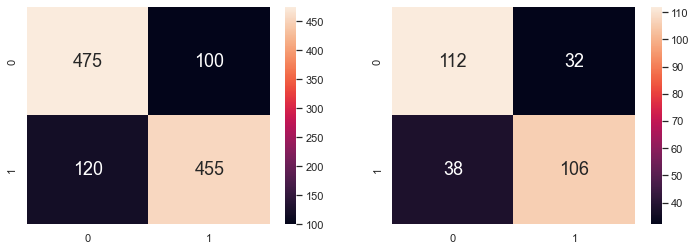

In [17]:
pred_train = best_abc.predict(X_train)
pred_test = best_abc.predict(X_test)

CM_train = confusion_matrix(y_train, pred_train)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", best_abc.score(X_train, y_train))
print("True Positive Rate \t\t:", TP_train/(TP_train + FN_train))
print("False Positive Rate \t\t:", FP_train/(FP_train + TN_train))

CM_test = confusion_matrix(y_test, pred_test)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0]
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", best_abc.score(X_test, y_test))
print("True Positive Rate \t\t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t\t:", FP_test/(FP_test + TN_test))
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, pred_train),
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, pred_test), 
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

We show the confusion matrix generated by the model for both the train dataset and the test dataset.

<h2> (6) CatBoost Classifier </h2>

The CatBoost Classifier is a high-performance open source library for gradient boosting on decision trees. In the growing procedure of the decision trees, CatBoost does not follow similar gradient boosting models. Instead, CatBoost grows oblivious trees, which means that the trees are grown by imposing the rule that all nodes at the same level, test the same predictor with the same condition, and hence an index of a leaf can be calculated with bitwise operations.

In [18]:
from catboost import CatBoostClassifier

param_grid = {'learning_rate': [0.08, 0.1, 0.15, 0.2, 0.25, 0.3], 
             'n_estimators': [200, 250, 300, 350, 400, 450, 500],
             'random_state': [42]}


grid_search_cbc = GridSearchCV(CatBoostClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_cbc.fit(X_train, y_train, silent=True)
print("Best parameters: ", grid_search_cbc.best_params_)
print("Best CV score: ", grid_search_cbc.best_score_)

best_cbc = CatBoostClassifier(**grid_search_cbc.best_params_).fit(X_train, y_train, silent=True)
print("Test accuracy: ", best_cbc.score(X_test, y_test))

Best parameters:  {'learning_rate': 0.1, 'n_estimators': 200, 'random_state': 42}
Best CV score:  0.757391304347826
Test accuracy:  0.7638888888888888


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9939130434782608
True Positive Rate 		: 0.9930434782608696
False Positive Rate 		: 0.0052173913043478265
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7638888888888888
True Positive Rate 		: 0.7361111111111112
False Positive Rate 		: 0.20833333333333334


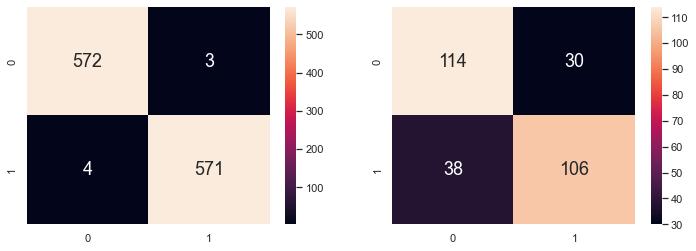

In [19]:
pred_train = best_cbc.predict(X_train)
pred_test = best_cbc.predict(X_test)

CM_train = confusion_matrix(y_train, pred_train)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", best_cbc.score(X_train, y_train))
print("True Positive Rate \t\t:", TP_train/(TP_train + FN_train))
print("False Positive Rate \t\t:", FP_train/(FP_train + TN_train))

CM_test = confusion_matrix(y_test, pred_test)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0]
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", best_cbc.score(X_test, y_test))
print("True Positive Rate \t\t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t\t:", FP_test/(FP_test + TN_test))
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, pred_train),
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, pred_test), 
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

We show the confusion matrix generated by the model for both the train dataset and the test dataset. As the model performs significantly better with the train dataset, the model may have been overfitted to the train dataset, and thus does not generalise to the test dataset very well.

<h2> (7) GradientBoost Classifier </h2>

Gradient Boosting Classifiers are the AdaBoosting method combined with weighted minimization, after which the classifiers and weighted inputs are recalculated. The objective of Gradient Boosting Classifiers is to minimize the loss, or the difference between the actual class value of the training example and the predicted class value.

In [20]:
param_grid = {'learning_rate':[0.008, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24], 
             'n_estimators': [100, 150, 200, 250, 300, 350, 400, 500, 550, 600],
             'random_state': [42]}

grid_search_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_gbc.fit(X_train,y_train)
print("Best parameters: ", grid_search_gbc.best_params_)
print("Best CV score: ", grid_search_gbc.best_score_)

best_gbc = GradientBoostingClassifier(**grid_search_gbc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_gbc.score(X_test, y_test))

Best parameters:  {'learning_rate': 0.008, 'n_estimators': 550, 'random_state': 42}
Best CV score:  0.7521739130434784
Test accuracy:  0.7638888888888888


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8217391304347826
True Positive Rate 		: 0.7791304347826087
False Positive Rate 		: 0.1356521739130435
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7638888888888888
True Positive Rate 		: 0.7013888888888888
False Positive Rate 		: 0.1736111111111111


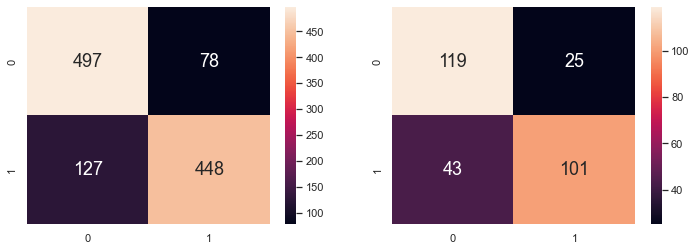

In [21]:
pred_train = best_gbc.predict(X_train)
pred_test = best_gbc.predict(X_test)

CM_train = confusion_matrix(y_train, pred_train)
TN_train = CM_train[0][0]
FN_train = CM_train[1][0]
TP_train = CM_train[1][1]
FP_train = CM_train[0][1]
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", best_gbc.score(X_train, y_train))
print("True Positive Rate \t\t:", TP_train/(TP_train + FN_train))
print("False Positive Rate \t\t:", FP_train/(FP_train + TN_train))

CM_test = confusion_matrix(y_test, pred_test)
TN_test = CM_test[0][0]
FN_test = CM_test[1][0]
TP_test = CM_test[1][1]
FP_test = CM_test[0][1]
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", best_gbc.score(X_test, y_test))
print("True Positive Rate \t\t:", TP_test/(TP_test + FN_test))
print("False Positive Rate \t\t:", FP_test/(FP_test + TN_test))
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, pred_train),
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, pred_test), 
             annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

We show the confusion matrix generated by the model for both the train dataset and the test dataset.

<h2> Conclusion </h2>

From the results obtained, we can see that Random Forest Classifier gives us the best test accuracy (77.43%) for this dataset. This model also gives a high True Postive Rate (74.31%), and a low False Positive Rate (19.44%). Hence, given the physicochemical properties of a wine, this model will be able to determine if this wine quality is good or bad, allowing consumers to make an informed decision when purchasing wines.

<h3> Insights on Results </h3>

Random Forest Classifier is the best here, likely because it adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in a better model.


Another insight is that our Forest and Boosting models were likely overfitted due to very high accuracy on the train set. This could be due to the predictors not having strong relationships with the final result of quality, making it difficult to be generalised, resulting in very deep forests with high maximum depth. Yet, these models still performed well after cross-validation. This suggests that the data in the test set resembles that in the train dataset, which still results in high accuracy for these models.

The Decision Tree Classifier performed poorly likely due to how fast the classifier overfits the training data. This leads to lower accuracy across the 5-fold cross validation set, and hence a tree with max depth of 4 had the highest accuracy after cross validation. However, the tree of depth 4 was likely not robust enough to accurately differentiate the wines and generalise to the test dataset.

An unexpected surprise was that Boosting Classifiers gave poorer results than Random Forest Classification. The points below serve to explain this result:
* AdaBoost uses decision stumps, which has only 1 node and 2 leaves, instead of the conventional decision trees. And in the next decision stump, more weights are assigned to the incorrectly classified samples, such that the model effectively learns from the mistakes of the previous stumps. This means that it emphasises on even the smallest error, and can overfit to the noise. And it is likely that our dataset has substantial noisy data due to SMOTE-ing.
* Decision trees in Gradient Boosting are built in a sequential manner where each tree effectively learns from the mistakes of the previous trees. This is similar to AdaBoost, meaning that the noise generated from SMOTE-ing have likely led to the poorer results.